<a href="https://colab.research.google.com/github/Jectrianama/GCCE_TEST/blob/main/GCECDL1/Fashion_Mnist_gcce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [77]:
#!pip install tensorflow==2.7.0
#!pip install scikeras

# Subclassing for GCCE

In [78]:
 
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import mode 
import numpy as np

def ook(t):
  lb = LabelBinarizer()
  y_ook = lb.fit_transform(t)  

  if len(np.unique(t))==2:
    y_ook = np.concatenate((1-y_ook.astype(bool), y_ook), axis = 1) 

  return y_ook

In [79]:
# -*- coding: utf-8 -*-
import tensorflow as tf
import matplotlib.pyplot as plt
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import tensorflow_probability as tfp
from tensorflow.keras import regularizers
from sklearn.base import  BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.model_selection import train_test_split
tf.keras.backend.clear_session()
#tf.random.set_seed(42)
import types
import tempfile
class Keras_MA_GCCE():  
 #Constructor __init__. Special method: identified by a double underscore at either side of their name
 #work in the background
 # initialize data members to the object. lets the class initialize the object’s attributes and serves no other purpose.
    def __init__(self,epochs=100,batch_size=30,R=5, K=2, dropout=0.5, learning_rate=1e-3,optimizer='Adam', 
                  l1_param=0, validation_split=0.3, verbose=1, q = 0.1, neurons=1.5, loss = "GCE" ):
        self.epochs=epochs
        self.dropout=dropout
        self.batch_size = batch_size
        self.learning_rate=learning_rate 
        self.l1_param=l1_param 
        self.l2_param=l1_param
        self.validation_split = validation_split
        self.verbose = verbose
        self.optimizer = optimizer
        self.R=R
        self.K=K
        self.q = q
        self.neurons = neurons
        self.loss = loss
    

    
 
    def GCE_MA_loss(self, y_true, y_pred):
        # print(y_true,y_pred)
       # q = 0.1
        pred = y_pred[:, self.R:]
        pred = tf.clip_by_value(pred, clip_value_min=1e-9, clip_value_max=1)
        ann_ = y_pred[:, :self.R]
        # ann_ = tf.clip_by_value(ann_, clip_value_min=1e-9, clip_value_max=1-1e-9)
        Y_true = tf.one_hot(tf.cast(y_true, dtype=tf.int32), depth=self.K, axis=1)
        #tf.print(tf.reduce_sum(Y_true[1,:,0]))
        #tf.print(y_true[1,0])
        Y_hat = tf.repeat(tf.expand_dims(pred,-1), self.R, axis = -1)

        p_gcce = Y_true*(1 - Y_hat**self.q)/self.q
        temp1 = ann_*tf.math.reduce_sum(p_gcce, axis=1)
        temp2 = (1 - ann_)*(1-(1/self.K)**self.q)/self.q*tf.reduce_sum(Y_true,axis=1)
        return tf.math.reduce_sum((temp1 + temp2))
    
    
    def custom_RCDNN_loss(self, y_true, y_pred):  #ytrue \in N x R,  ypred \in N x (R+K) -> PRI->JULI
    
        #Input ytrue: samples (N) x  annotators (R) 
        #Input ypred: samples (N) x  annotators+classes (R+K) 

        #Ground truth estimation samples (N) x  Classes(K)
        pred = y_pred[:,self.R:]
        pred = tf.clip_by_value(pred, clip_value_min=1e-9, clip_value_max=1-1e-9) #estabilidad numerica de la funcion de costo
        # Annotators reliability prediction: samples (N) x  annotators (R)
        ann_ = y_pred[:,:self.R]
        #Y_true 1-K: samples (N) x  Classes(1-K), annotators (R)
        Y_true = tf.one_hot(tf.cast(y_true, dtype=tf.int32), depth=self.K, axis=1)
        #Y_pred 1 - K: samples (N) x  Classes(1-K), annotators (R)
        Y_hat = tf.repeat(tf.expand_dims(pred,-1), self.R, axis = -1)
        #loss computation
        p_logreg = tf.math.reduce_prod(tf.math.pow(Y_hat, Y_true), axis=1)
        temp1 = ann_*tf.math.log(p_logreg)  
        temp2 = (1 - ann_)*tf.math.log(1/self.K)*tf.reduce_sum(Y_true,axis=1)
        # temp2 = (tf.ones(tf.shape(ann_)) - ann_)*tf.math.log(1/K)
        # print(tf.reduce_mean(Y_true,axis=1).numpy())
        return -tf.math.reduce_sum((temp1 + temp2))

 
    def PRI_MA_loss(self, y_true, y_pred): #,  -> PRI
        #Input ytrue: samples (N) x  annotators (R) 
        #Input ypred: samples (N) x  annotators+classes (R+K) 
        #PRI MA
        cce_M = tf.keras.losses.CategoricalCrossentropy(reduction='none',axis=-1)
        cce_C = tf.keras.losses.CategoricalCrossentropy(reduction='none',axis=1)

      

        #N = tf.cast(y_true.shape[0],dtype=tf.int32)
        N = tf.shape(y_true)[0]
        #Ground truth estimation samples (N) x  Classes(K)
        y_pred_tf = y_pred[:,self.R:] 
        # Annotators reliability prediction: samples (N) x  annotators (R)
        lambda_R_tf = y_pred[:,:self.R] #tf.ones(shape=(N,R)) 
        #Y_true 1 K: samples (N) x  Classes(1-K), annotators (R)
        Y_true_1K = tf.one_hot(tf.cast(y_true,dtype=tf.int32),depth=self.K,axis=1)  
        #Y_pred 1 - K: samples (N) x  Classes(1-K), annotators (R)
        Y_hat = tf.repeat(tf.expand_dims(y_pred_tf,-1), self.R, axis = -1) 
        #marginal entropy
        #cce along the K classes -> ypred_tf
        Hm_ = cce_M(y_pred_tf,y_pred_tf)
        #cross entropy
        #cce along the K classes -> Y_hat
        Hc_ = cce_C(Y_true_1K,Y_hat)
        #PRI MA computation
        LH = tf.linalg.matmul(lambda_R_tf,Hc_,transpose_a=True) # \Lambda^\top H_c
        temp1 = tf.linalg.trace(LH) #trace(LH)
        Hm1L = tf.linalg.matmul(tf.ones(shape=(N,self.R))-lambda_R_tf,tf.ones(shape=(self.R,1)))# 1_N 1_R^\top - Lambda
        Hm_t = tf.reshape(Hm_,shape=(N,1))
        temp2 = tf.squeeze(tf.linalg.matmul(Hm_t,Hm1L,transpose_a=True)) # Hm^\top Hm1L
        loss_c = temp1+ temp2 #return loss

        return loss_c

    def fit(self, X, Y):
        
        def scheduler1(step = 10, ratio = 1.2):
            def scheduler(epoch, lr):
                if epoch % step == 0 and epoch>1:
                    return lr/ratio
                else:
                    return lr
            return scheduler

        initializer = tf.keras.initializers.GlorotNormal(seed=100)
        #input X numpy array first dimension samples (N)x features (P)
        #input Y numpy array vector len = samples (N) x  annotators (R)
        P = X.shape[1]
        
        if self.optimizer == "Adam":
            opt = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        elif self.optimizer == "SGD":
            opt = tf.keras.optimizers.SGD(learning_rate=self.learning_rate)
        elif self.optimizer == "RMSprop":
            opt = tf.keras.optimizers.RMSprop(learning_rate=self.learning_rate)
        elif self.optimizer == "Adagrad":
            opt = tf.keras.optimizers.Adagrad(learning_rate=self.learning_rate)
        else:
            opt=self.optimizer


        if self.loss == "RCDNN":
          sel_loss = self.custom_RCDNN_loss
        elif  self.loss == "GCE":
          sel_loss = self.GCE_MA_loss
        
        #capa de entrada
        input_l = tf.keras.layers.Input(shape=(X_train.shape[1]), name='entrada')
        input_l_b = tf.keras.layers.BatchNormalization()(input_l)        
        input_l_do = tf.keras.layers.Dropout(rate=self.dropout)(input_l_b)    
        #capas densas
        h1 = tf.keras.layers.Dense(int(200),activation='selu',name='h1', bias_initializer='zeros', kernel_initializer=initializer,
                              kernel_regularizer=tf.keras.regularizers.l1_l2(l1=self.l1_param,l2=self.l2_param))(input_l_do)#argumento de entrada
       # h1 = tf.keras.layers.BatchNormalization()(h1)        
        h1 = tf.keras.layers.AlphaDropout(rate=self.dropout)(h1)      
        h2 = tf.keras.layers.Dense(int(50),activation='selu',name='h2', bias_initializer='zeros', kernel_initializer=initializer,
                              kernel_regularizer=tf.keras.regularizers.l1_l2(l1=self.l1_param,l2=self.l2_param))(h1)
        #h2 = tf.keras.layers.BatchNormalization()(h2)     
        dout = tf.keras.layers.AlphaDropout(rate=self.dropout)(h2)
        output_R = tf.keras.layers.Dense(self.R,activation="sigmoid", bias_initializer='zeros', kernel_initializer=initializer,
                                    kernel_regularizer=tf.keras.regularizers.l1_l2(l1=self.l1_param,l2=self.l2_param), name= 'out_R_GCCE' )(dout)
 
        output_K = tf.keras.layers.Dense(self.K,activation="softmax", bias_initializer='zeros', kernel_initializer=initializer,
                                    kernel_regularizer=tf.keras.regularizers.l1_l2(l1=self.l1_param,l2=self.l2_param), name= 'out_K_GCCE')(dout)
 
        output = tf.keras.layers.concatenate([output_R, output_K])
        self.model = tf.keras.Model(inputs= input_l,outputs=output)
        self.model.compile(loss=sel_loss, optimizer=opt)

        callback1 = tf.keras.callbacks.TerminateOnNaN()
        callback2 = tf.keras.callbacks.LearningRateScheduler(scheduler1(ratio = 1))
        #callback2 = tf.keras.callbacks.LearningRateScheduler(scheduler2)
        callback3 = tf.keras.callbacks.EarlyStopping(monitor="loss", min_delta=1e-2,
                                                 patience=15, verbose=0, mode="auto",
                                                 baseline=None, restore_best_weights=True)
            
 
        self.history = self.model.fit(X, Y, epochs=self.epochs, validation_split=self.validation_split, callbacks = [callback1, callback2],   #
                                      batch_size=self.batch_size,verbose=self.verbose, shuffle = True)
 
        return self
 
  
  
    
    def predict(self, X, *_):
       #input X numpy array first dimension samples (N)x features (P)
      return  self.model.predict(X) 
 
 

    def fit_predict(self,X,y):
        #input X numpy array first dimension samples (N)x features (P)
        #input Y numpy array vector len = samples (N) x  annotators (R)
        self.fit(X,y)
        return self.predict(X)
    
    def model_MC(self, X, *_):
       #input X numpy array first dimension samples (N)x features (P)
        return  self.model(X, training=True) 
 
  
     #graphics
    def plot_history(self):
        pd.DataFrame(self.history.history).plot(figsize=(8, 5))
        plt.grid(True)
        #plt.gca().set_ylim(0, 1)
        #save_fig("keras_learning_curves_plot")
        plt.show()
        return
    
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)

        return self
    
    
    
    def get_params(self, deep=True):
        return { 'l1_param':self.l1_param, 'dropout':self.dropout, 'optimizer':self.optimizer,
                'learning_rate':self.learning_rate, 'batch_size':self.batch_size,
                'epochs':self.epochs, 'verbose':self.verbose, 'validation_split':self.validation_split,
                'R':self.R, 'K':self.K, 'q':self.q
                }

  
        return self


In [80]:
!git clone https://github.com/Jectrianama/GCCE_TEST.git

fatal: destination path 'GCCE_TEST' already exists and is not an empty directory.


In [81]:
import os
os.chdir('/content/GCCE_TEST/Models')
from labels_generation import MA_Clas_Gen

# Load Data

In [82]:
#load data
import scipy.io as sio
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf #importar tensorflow
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import numpy as np
database = 'Fashion-Mnist' #['bupa1', 'breast-cancer-wisconsin1','pima-indians-diabetes1', 'ionosphere1', 'tic-tac-toe1', 'iris1', 'wine1', 'segmentation1']


# path_ = 'MADatasets/'+ database+ '.mat' 
# Xdata = sio.loadmat(path_)
# Xdata.keys()


In [83]:
(X, t), _ = tf.keras.datasets.fashion_mnist.load_data()
t=t+1
X = X.reshape(len(X),-1)

# Labels Generation  

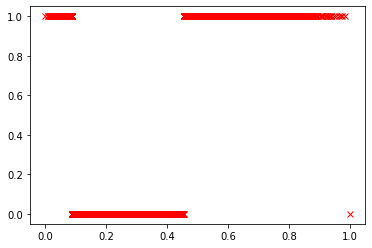

In [84]:
Y, iAnn, Lam_r = MA_Clas_Gen(X ,t, R=5, NrP=1)

In [85]:

Y = Y - 1
t = t - 1
#YMA = YMA-1


annotator 1
              precision    recall  f1-score   support

           0       0.84      0.76      0.80      6000
           1       0.86      0.99      0.92      6000
           2       0.84      0.70      0.76      6000
           3       0.86      0.97      0.91      6000
           4       0.84      0.61      0.70      6000
           5       0.86      1.00      0.92      6000
           6       0.84      0.78      0.81      6000
           7       0.86      1.00      0.92      6000
           8       0.84      0.77      0.81      6000
           9       0.86      0.92      0.89      6000

    accuracy                           0.85     60000
   macro avg       0.85      0.85      0.85     60000
weighted avg       0.85      0.85      0.85     60000

annotator 2
              precision    recall  f1-score   support

           0       0.75      0.65      0.70      6000
           1       0.79      0.96      0.87      6000
           2       0.76      0.70      0.72      6000


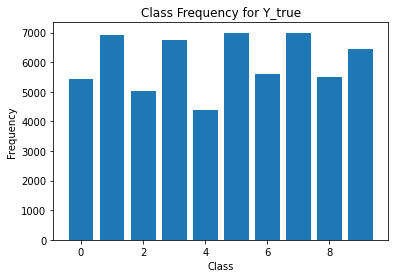

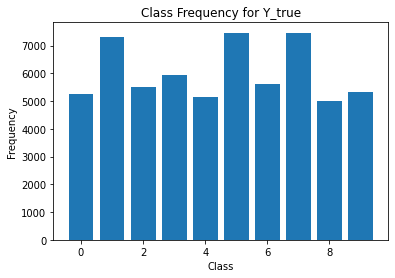

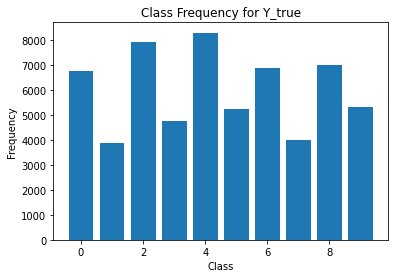

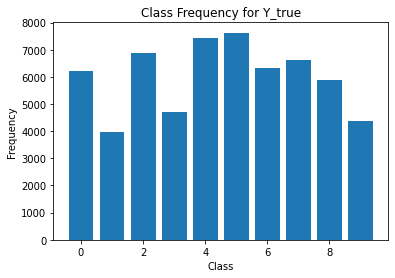

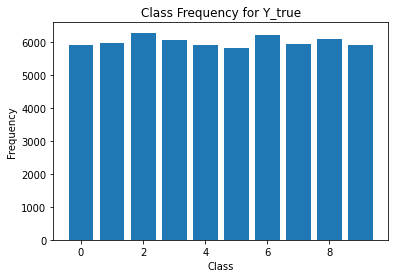

In [86]:
from sklearn.metrics import classification_report
for i in range(Y.shape[1]):
    print('annotator',i+1)
    print(classification_report(t,Y[:,i]))
    unique, counts = np.unique(Y[:,i], return_counts=True)
    plt.figure()
    plt.bar(unique, counts)
#     unique, counts = np.unique(Y_test[5], return_counts=True)
#     plt.bar(unique, counts)

    plt.title('Class Frequency for Y_true')
    plt.xlabel('Class')
    plt.ylabel('Frequency')


# Split data

In [87]:
import numpy.matlib
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
Ns = 1
ss = ShuffleSplit(n_splits=Ns, test_size=0.3,random_state =123)
for train_index, test_index in ss.split(X):
    print(test_index)
    X_train, X_test,Y_train,Y_test = X[train_index,:], X[test_index,:],Y[train_index,:], Y[test_index,:]
    Y_true_train, Y_true_test = t[train_index].reshape(-1,1), t[test_index].reshape(-1,1)
print(X_train.shape, Y_train.shape, Y_true_train.shape)

[29561 26640 24498 ... 18948 24384 48300]
(42000, 784) (42000, 5) (42000, 1)


# Apply MinMaxScaler

In [88]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Testing the Class 


iteration: 0


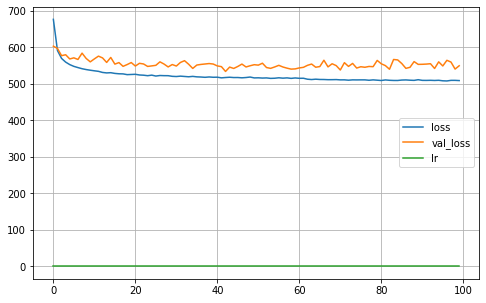

563/563 [==============================] - 1s 2ms/step
Validation ACC: 0.8650
Validation Balanced_ACC: 0.8495
Validation MI: 1.7986
Validation Normalized MI: 0.7832
Validation Adjusted MI: 0.7830
Validation aUc: 0.9257
Validation aUc_Sklearn: 0.9866
iteration: 1


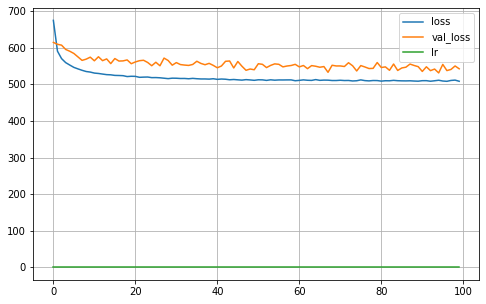

563/563 [==============================] - 1s 2ms/step
Validation ACC: 0.8668
Validation Balanced_ACC: 0.8516
Validation MI: 1.8022
Validation Normalized MI: 0.7838
Validation Adjusted MI: 0.7836
Validation aUc: 0.9201
Validation aUc_Sklearn: 0.9864
iteration: 2


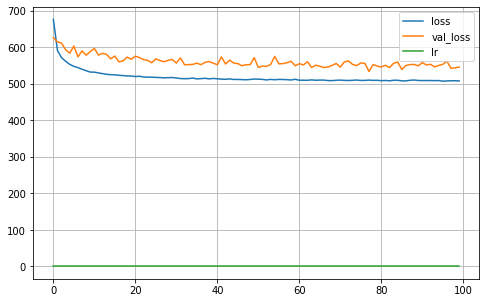

563/563 [==============================] - 1s 2ms/step
Validation ACC: 0.8643
Validation Balanced_ACC: 0.8489
Validation MI: 1.7969
Validation Normalized MI: 0.7821
Validation Adjusted MI: 0.7819
Validation aUc: 0.9190
Validation aUc_Sklearn: 0.9858
iteration: 3


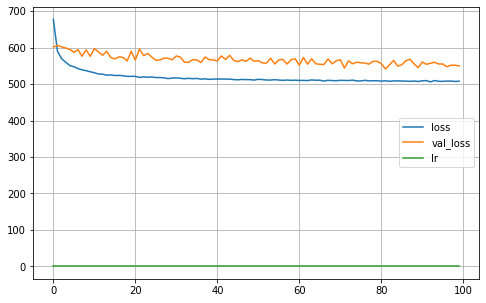

563/563 [==============================] - 1s 2ms/step
Validation ACC: 0.8651
Validation Balanced_ACC: 0.8497
Validation MI: 1.7962
Validation Normalized MI: 0.7816
Validation Adjusted MI: 0.7814
Validation aUc: 0.9181
Validation aUc_Sklearn: 0.9863
iteration: 4


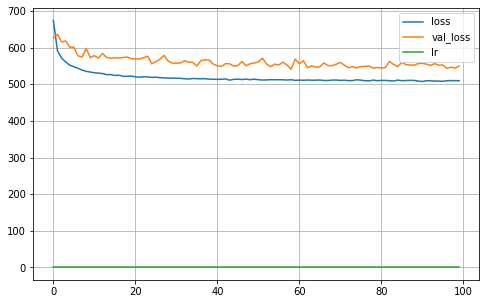

563/563 [==============================] - 1s 2ms/step
Validation ACC: 0.8666
Validation Balanced_ACC: 0.8513
Validation MI: 1.8069
Validation Normalized MI: 0.7868
Validation Adjusted MI: 0.7866
Validation aUc: 0.9355
Validation aUc_Sklearn: 0.9863
iteration: 5


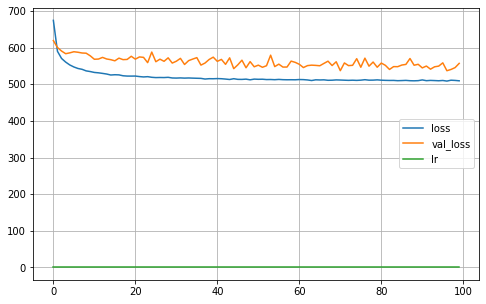

563/563 [==============================] - 1s 2ms/step
Validation ACC: 0.8661
Validation Balanced_ACC: 0.8506
Validation MI: 1.8047
Validation Normalized MI: 0.7868
Validation Adjusted MI: 0.7866
Validation aUc: 0.9393
Validation aUc_Sklearn: 0.9866
iteration: 6


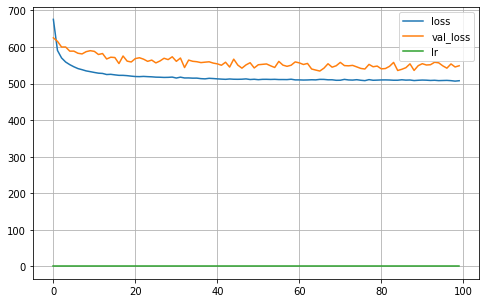

563/563 [==============================] - 1s 2ms/step
Validation ACC: 0.8678
Validation Balanced_ACC: 0.8527
Validation MI: 1.8049
Validation Normalized MI: 0.7852
Validation Adjusted MI: 0.7850
Validation aUc: 0.9214
Validation aUc_Sklearn: 0.9865
iteration: 7


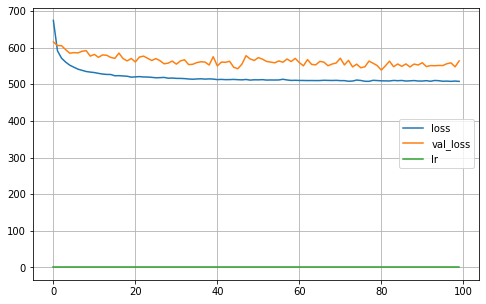

563/563 [==============================] - 1s 2ms/step
Validation ACC: 0.8633
Validation Balanced_ACC: 0.8477
Validation MI: 1.7942
Validation Normalized MI: 0.7810
Validation Adjusted MI: 0.7808
Validation aUc: 0.9229
Validation aUc_Sklearn: 0.9858
iteration: 8


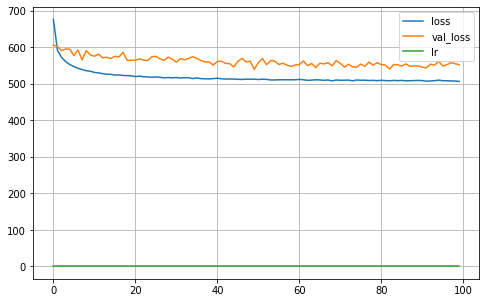

563/563 [==============================] - 1s 2ms/step
Validation ACC: 0.8668
Validation Balanced_ACC: 0.8516
Validation MI: 1.8019
Validation Normalized MI: 0.7841
Validation Adjusted MI: 0.7839
Validation aUc: 0.9208
Validation aUc_Sklearn: 0.9861
iteration: 9


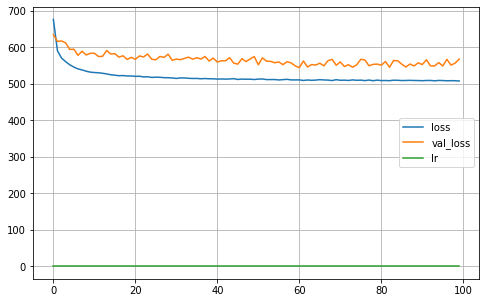

563/563 [==============================] - 1s 2ms/step
Validation ACC: 0.8657
Validation Balanced_ACC: 0.8503
Validation MI: 1.7999
Validation Normalized MI: 0.7836
Validation Adjusted MI: 0.7834
Validation aUc: 0.9300
Validation aUc_Sklearn: 0.9859


In [89]:
from sklearn.metrics import classification_report, balanced_accuracy_score, roc_auc_score
from sklearn.metrics import normalized_mutual_info_score, mutual_info_score, adjusted_mutual_info_score
l1 =0.0001
NUM_RUNS =10
ACC = np.zeros(NUM_RUNS)
AUC = np.zeros(NUM_RUNS)
AUCSK = np.zeros(NUM_RUNS)
MI = np.zeros(NUM_RUNS)
NMI = np.zeros(NUM_RUNS)
AMI = np.zeros(NUM_RUNS)
BACC = np.zeros(NUM_RUNS)
for i in range(NUM_RUNS): #10
    print("iteration: " + str(i))
   
    MA = Keras_MA_GCCE(epochs=100,batch_size=64,R=5, K=len(np.unique(Y_true_train)), dropout=0.5, learning_rate=0.001,optimizer='Adam', 
                l1_param=l1,  validation_split=0.30, verbose=0, q=0.01, neurons=4)


    MA.fit(X_train, Y_train)
    MA.plot_history()
  
    #Accuracy
    pred_2 = MA.predict(X_test)
 
    report = classification_report( pred_2[:,Y.shape[1]:].argmax(axis=1),Y_true_test.ravel(),output_dict=True)
    ACC[i] = report['accuracy']
    print("Validation ACC: %.4f" % (float(ACC[i])))


    # balanced. Accurcy
    BACC[i] = balanced_accuracy_score(Y_true_test.squeeze(), pred_2[:,Y.shape[1]:].argmax(axis=1).squeeze(), adjusted=True)
    print("Validation Balanced_ACC: %.4f" % (float(BACC[i])))

    #MI
    
    MI[i] = mutual_info_score(Y_true_test.squeeze(), pred_2[:,Y.shape[1]:].argmax(axis=1).squeeze())
    print("Validation MI: %.4f" % (float(MI[i]),))
    NMI[i] = normalized_mutual_info_score(Y_true_test.squeeze(), pred_2[:,Y.shape[1]:].argmax(axis=1).squeeze())
    print("Validation Normalized MI: %.4f" % (float(NMI[i]),))
    AMI[i]= adjusted_mutual_info_score(Y_true_test.squeeze(), pred_2[:,Y.shape[1]:].argmax(axis=1).squeeze())
    print("Validation Adjusted MI: %.4f" % (float(AMI[i]),))


    #AUC
    val_AUC_metric = tf.keras.metrics.AUC( from_logits = True)  
   # val_logits =MA.predict(X_test) # model(X_test, training=False)
    # tf.print(y_batch_val)
    val_AUC_metric.update_state(Y_true_test, pred_2[:,Y.shape[1]:].argmax(axis=1).astype('float'))

    val_AUC = val_AUC_metric.result()
    val_AUC_metric.reset_states()
    val_AUC = val_AUC.numpy()
    print("Validation aUc: %.4f" % (float(val_AUC),))
    AUC[i] = val_AUC
    val_AUC1 = roc_auc_score(ook(Y_true_test), pred_2[:,Y_train.shape[1]:])
    print("Validation aUc_Sklearn: %.4f" % (float(val_AUC1),))
    AUCSK[i] = val_AUC1


In [90]:

ACC

array([0.865     , 0.86683333, 0.86433333, 0.86511111, 0.86661111,
       0.86611111, 0.86783333, 0.86327778, 0.86683333, 0.86572222])

In [91]:

AUC

array([0.92572421, 0.92005491, 0.91897702, 0.91814601, 0.93552113,
       0.9392525 , 0.92142498, 0.92291939, 0.92080575, 0.93003827])

In [92]:
print('Average Accuracy: ', np.round( ACC.mean(),4)*100) 
print('Average std: ',np.round(np.std( ACC),4)*100)
print('==============================================')
print('Average AUC: ', np.round( AUC.mean(),4)*100) 
print('Average AUC std: ',np.round(np.std( AUC),4)*100)
print('==============================================')
print('Average AUC Sklearn: ', np.round( AUCSK.mean(),4)*100) 
print('Average AUC SK std: ',np.round(np.std( AUCSK),4)*100)
print('==============================================')
print('Average Balanced Accuracy: ', np.round( BACC.mean(),4)*100) 
print('Average std: ',np.round(np.std( BACC),4)*100)
print('==============================================')
print('Average MI: ', np.round( MI.mean(),4)*100) 
print('Average std: ',np.round(np.std(MI),4)*100)
print('==============================================')
print('Average Normalized MI: ', np.round( NMI.mean(),4)*100) 
print('Average std: ',np.round(np.std(NMI),4)*100)
print('==============================================')
print('Average Ajdusted MI: ', np.round( AMI.mean(),4)*100) 
print('Average std: ',np.round(np.std(AMI),4)*100)

Average Accuracy:  86.58
Average std:  0.13
Average AUC:  92.53
Average AUC std:  0.69
Average AUC Sklearn:  98.61999999999999
Average AUC SK std:  0.03
Average Balanced Accuracy:  85.04
Average std:  0.13999999999999999
Average MI:  180.06
Average std:  0.4
Average Normalized MI:  78.38000000000001
Average std:  0.19
Average Ajdusted MI:  78.36
Average std:  0.19


In [93]:
import pickle

# create the dictionary with 6 scalar variables
Metrics = {
    'Accuracy': np.round( ACC.mean(),4)*100,
    'Accuracy_std': np.round(np.std( ACC),4)*100,
    'AUC': np.round( AUC.mean(),4)*100,
    'AUC_std': np.round(np.std( AUC),4)*100,
    'AUCSK': np.round( AUCSK.mean(),4)*100,
    'AUCSK_std': np.round(np.std( AUCSK),4)*100,
    'Balanced Accuracy': np.round( BACC.mean(),4)*100,
    'Balanced Accuracy_std':  np.round(np.std(BACC),4)*100,
    'MI': np.round( MI.mean(),4)*100,
    'MI_std': np.round(np.std(MI),4)*100,
    'Normalized MI': np.round( NMI.mean(),4)*100,
    'Normalized MI_std': np.round(np.std(NMI),4)*100,
    'Adjusted MI': np.round( AMI.mean(),4)*100,
    'Adjusted MI_std': np.round(np.std(NMI),4)*100,
}

# save the dictionary to a file using pickle
with open('data.pickle', 'wb') as handle:
    pickle.dump(Metrics, handle, protocol=pickle.HIGHEST_PROTOCOL)

    pickle.dump(Metrics, handle, protocol=pickle.HIGHEST_PROTOCOL)

Metrics

IndentationError: ignored